<a href="https://colab.research.google.com/github/Theanh130124/SIC_Plagiarism_Detector/blob/random_forest/Plagiarism_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [13]:
!pip install contractions

In [14]:
import re
import pandas as pd
import numpy as np
import nltk
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import contractions # can't -> cannot
import kagglehub
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

#Load Dataset

In [15]:
path = kagglehub.dataset_download("ruvelpereira/mit-plagairism-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mit-plagairism-detection-dataset


In [17]:
file_path = os.path.join(path, "train_snli.txt")
with open(file_path, encoding='utf-8') as file:
    data = file.readlines()


with open('data.csv', 'w', newline= '') as csvfile:
  filenames = ['source_txt', 'plagiarism_txt', 'label']
  writer = csv.DictWriter(csvfile, fieldnames=filenames)
  writer.writeheader()
  for line in tqdm(data):
    parts = line.strip().split('\t')
    source_txt = parts[0]
    plagiarism_txt = parts[1]
    label = parts[2]
    writer.writerow({'source_txt': source_txt, 'plagiarism_txt': plagiarism_txt, 'label': label})
print('CSV file created successfully...')


  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


#Check Sample

In [19]:
df = pd.read_csv('/content/data.csv')
df.sample(5) #random

,source_txt,plagiarism_txt,label
146453,This person is doing a stunt on a motorcycle.,A daredevil is on a tightrope.,0
122616,people are playing a carnival game.,a penguin is jumping,0
236192,A man in black approaches a strange silver obj...,A man in black is alone.,0
211876,"There are five people in the picture, two guys...",The streets are completely empty.,0
40710,"A hippie couple is walking through the city, b...",Two hippies are laying in the hammock.,0


#Shape of Data

In [20]:
df.shape

(367373, 3)

#Check Mising Values

In [21]:
print("Null values",df.isnull().sum())
#remove null
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


#Check Duplicate

In [22]:
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


#Check Values Count

label
0    183874
1    183041
Name: count, dtype: int64


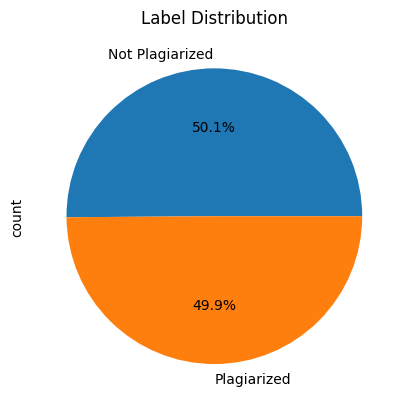

In [23]:
# check value counts  -> Ktra dataset cân bằng
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()